In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import runProcs
import os
plt.style.use('classic')
%matplotlib inline

# Cross Country Income Data

This program extracts particular series from the Penn World Tables (PWT). Data and documentation for the PWT are available at https://pwt.sas.upenn.edu/. For additional reference see the article "The Next Generation of the Penn World Table" by Feenstra, Inklaar, and Timmer in the October 2015 issue of the *American Economic Review* (https://www.aeaweb.org/articles?id=10.1257/aer.20130954)

## Import data and manage

In [2]:
# Set the current value of the PWT data file
current_pwt_file = 'pwt100.xlsx'

In [3]:
# Import data from local source or download if not present
if os.path.exists('../xslx/pwt100.xlsx'):
    info = pd.read_excel('../xslx/'+current_pwt_file,sheet_name='Info',header=None)
    legend = pd.read_excel('../xslx/'+current_pwt_file,sheet_name='Legend',index_col=0)
    pwt = pd.read_excel('../xslx/'+current_pwt_file,sheet_name='Data',index_col=3,parse_dates=True)

else:
    info = pd.read_excel('https://www.rug.nl/ggdc/docs/'+current_pwt_file,sheet_name='Info',header=None)
    legend = pd.read_excel('https://www.rug.nl/ggdc/docs/'+current_pwt_file,sheet_name='Legend',index_col=0)
    pwt = pd.read_excel('https://www.rug.nl/ggdc/docs/'+current_pwt_file,sheet_name='Data',index_col=3,parse_dates=True)

In [4]:
# Find PWT version
version = info.iloc[0][0].split(' ')[-1]

# Find base year for real variables
base_year = legend.loc['rgdpe']['Variable definition'].split(' ')[-1].split('US')[0]

# Write to file
with open('../txt/pwt_metadata.txt','w') as newfile:
    newfile.writelines([version,base_year])

In [5]:
# Replace Côte d'Ivoire with Cote d'Ivoire
pwt['country'] = pwt['country'].str.replace(u"Côte d'Ivoire",u"Cote d'Ivoire")

# Merge country name and code
pwt['country'] = pwt['country']+' - '+pwt['countrycode']

# Create hierarchical index
pwt = pwt.set_index(['country',pwt.index])

# Display new DataFrame
pwt

countrycode   currency_unit         rgdpe  \
country        year                                                   
Aruba - ABW    1950-01-01         ABW  Aruban Guilder           NaN   
               1951-01-01         ABW  Aruban Guilder           NaN   
               1952-01-01         ABW  Aruban Guilder           NaN   
               1953-01-01         ABW  Aruban Guilder           NaN   
               1954-01-01         ABW  Aruban Guilder           NaN   
...                               ...             ...           ...   
Zimbabwe - ZWE 2015-01-01         ZWE       US Dollar  40141.617188   
               2016-01-01         ZWE       US Dollar  41875.203125   
               2017-01-01         ZWE       US Dollar  44672.175781   
               2018-01-01         ZWE       US Dollar  44325.109375   
               2019-01-01         ZWE       US Dollar  42296.062500   

                                  rgdpo        pop       emp  avh        hc  \
country        year                                                           
Aruba - ABW    1950-01-01           NaN        NaN       NaN  NaN       NaN   
               1951-01-01           NaN        NaN       NaN  NaN       NaN   
               1952-01-01           NaN        NaN       NaN  NaN       NaN   
               1953-01-01           NaN        NaN       NaN  NaN       NaN   
               1954-01-01           NaN        NaN       NaN  NaN       NaN   
...                                 ...        ...       ...  ...       ...   
Zimbabwe - ZWE 2015-01-01  39798.644531  13.814629  6.393752  NaN  2.584653   
               2016-01-01  40963.191406  14.030331  6.504374  NaN  2.616257   
               2017-01-01  44316.742188  14.236595  6.611773  NaN  2.648248   
               2018-01-01  43420.898438  14.438802  6.714952  NaN  2.680630   
               2019-01-01  40826.570312  14.645468  6.831017  NaN  2.713408   

                                   ccon           cda  ...     csh_x  \
country        year                                    ...             
Aruba - ABW    1950-01-01           NaN           NaN  ...       NaN   
               1951-01-01           NaN           NaN  ...       NaN   
               1952-01-01           NaN           NaN  ...       NaN   
               1953-01-01           NaN           NaN  ...       NaN   
               1954-01-01           NaN           NaN  ...       NaN   
...                                 ...           ...  ...       ...   
Zimbabwe - ZWE 2015-01-01  44249.355469  47325.460938  ...  0.140172   
               2016-01-01  43291.566406  46404.160156  ...  0.131920   
               2017-01-01  46113.945312  49457.570312  ...  0.126722   
               2018-01-01  46198.441406  49665.386719  ...  0.144485   
               2019-01-01  43961.839844  47128.785156  ...  0.213562   

                              csh_m     csh_r      pl_c      pl_i      pl_g  \
country        year                                                           
Aruba - ABW    1950-01-01       NaN       NaN       NaN       NaN       NaN   
               1951-01-01       NaN       NaN       NaN       NaN       NaN   
               1952-01-01       NaN       NaN       NaN       NaN       NaN   
               1953-01-01       NaN       NaN       NaN       NaN       NaN   
               1954-01-01       NaN       NaN       NaN       NaN       NaN   
...                             ...       ...       ...       ...       ...   
Zimbabwe - ZWE 2015-01-01 -0.287693 -0.051930  0.479228  0.651287  0.541446   
               2016-01-01 -0.251232 -0.016258  0.470640  0.651027  0.539631   
               2017-01-01 -0.202827 -0.039897  0.473560  0.639560  0.519956   
               2018-01-01 -0.263658 -0.020791  0.543757  0.655473  0.529867   
               2019-01-01 -0.270959 -0.089798  0.494755  0.652439  0.500927   

                               pl_x      pl_m      pl_n      pl_k  
country        year                      

## Contstruct data sets

In [6]:
# Define a function that constructs data sets
def create_data_set(year0,pwtCode,per_capita,per_worker):
    
    year0 = str(year0)
    
    if per_capita:
        data = pwt[pwtCode]/pwt['pop']
        
    elif per_worker:
        data = pwt[pwtCode]/pwt['emp']
        
    else:
        data = pwt[pwtCode]
        
    data = data.unstack(level='country').loc[year0:].dropna(axis=1)
    
    return data

### GDP data

In [7]:
# Create data sets
gdp_pc = create_data_set(year0=1960,pwtCode='cgdpe',per_capita=True,per_worker=False)
consumption_pc = create_data_set(year0=1960,pwtCode='ccon',per_capita=True,per_worker=False)
physical_capital_pc = create_data_set(year0=1960,pwtCode='cn',per_capita=True,per_worker=False)
human_capital_pc = create_data_set(year0=1960,pwtCode='hc',per_capita=False,per_worker=False)

# Find intsection of countries with data from 1960
intersection = gdp_pc.columns.intersection(consumption_pc.columns).intersection(physical_capital_pc.columns).intersection(human_capital_pc.columns)

# Adjust data
gdp_pc = gdp_pc[intersection]
consumption_pc = consumption_pc[intersection]
physical_capital_pc = physical_capital_pc[intersection]
human_capital_pc = human_capital_pc[intersection]

# Export to csv
gdp_pc.to_csv('../csv/cross_country_gdp_per_capita.csv')
consumption_pc.to_csv('../csv/cross_country_consumption_per_capita.csv')
physical_capital_pc.to_csv('../csv/cross_country_physical_capital_per_capita.csv')
human_capital_pc.to_csv('../csv/cross_country_human_capital_per_capita.csv')

## Plot for website

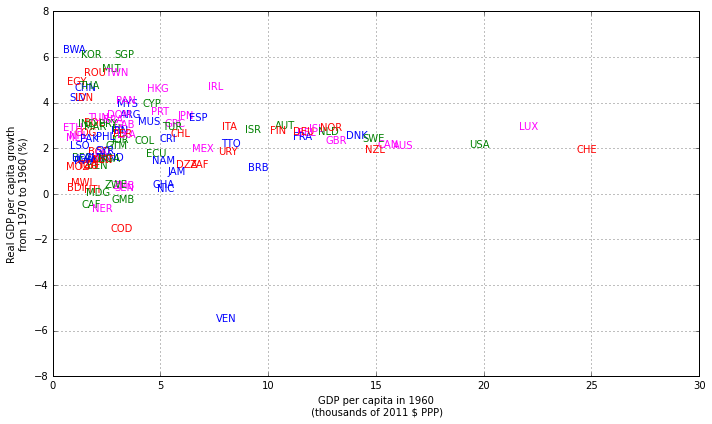

In [8]:
# Load data
df = pd.read_csv('../csv/cross_country_gdp_per_capita.csv',index_col='year',parse_dates=True)
income60 = df.iloc[0]/1000
growth = 100*((df.iloc[-1]/df.iloc[0])**(1/(len(df.index)-1))-1)

# Construct plot
fig = plt.figure(figsize=(10, 6)) 
ax = fig.add_subplot(1,1,1)
colors = ['red','blue','magenta','green']

plt.scatter(income60,growth,s=0.0001)
for i, txt in enumerate(df.columns):
    
    ax.annotate(txt[-3:], (income60[i],growth[i]),fontsize=10,color = colors[np.mod(i,4)])
ax.grid()

ax.set_xlabel('GDP per capita in 1960\n (thousands of 2011 $ PPP)')
ax.set_ylabel('Real GDP per capita growth\nfrom 1970 to '+str(df.index[0].year)+ ' (%)')
xlim = ax.get_xlim()
ax.set_xlim([0,xlim[1]])

fig.tight_layout()

# Save image
plt.savefig('../png/fig_GDP_GDP_Growth_site.png',bbox_inches='tight')

In [9]:
# Export notebook to python script
runProcs.exportNb('cross_country_income_data')